### Authenticate

The Gemini API lets you tune models on your own data. Since it's your data and
your tuned models this needs stricter access controls than API-Keys can provide.

Before you can run this tutorial, you'll need to
[setup OAuth for your project](https://ai.google.dev/gemini-api/docs/oauth).


In Colab the easiest wat to get setup is to copy the contents of your `client_secret.json` file into Colab's "Secrets manager" (under the key icon in the left panel) with the secret name `CLIENT_SECRET`.

This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

> Important: If you're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.


In [ ]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  from google.colab import userdata
  import pathlib
  pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

### Install the client library

In [ ]:
!pip install -q google-generativeai

### Import libraries

In [ ]:
import google.generativeai as genai

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [ ]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

### Preprocessing the dataset of news

In [ ]:
!pip install -q datasets
!python -m spacy download es_core_news_lg

In [ ]:
from datasets import load_dataset
import spacy

In [ ]:
nlp = spacy.load("es_core_news_lg")
data = load_dataset("BrauuHdzM/Noticias-con-resumen")

In [ ]:
def extract_first_loc(text):
    doc = nlp(text)
    first_loc = next((ent.text for ent in doc.ents if ent.label_ == "LOC"), None) # Find the first entity of type LOC

    return first_loc

In [ ]:
def format_conversation(context, example):

    formatted_conversation = []

    # Preparar el contenido basado en si existe una ubicación o no
    if extract_first_loc(example["Contenido"]):
        text_input = context + "Crea un artículo de noticias con esta información: " + example["resumen"] + ". " + "Fecha: " + example["Fecha"] + ". Lugar: " + extract_first_loc(example["Contenido"])
        output = "El " + example["Fecha"] +  ", en " + extract_first_loc(example["Contenido"]) + ". " + example["Contenido"]
    else:
        text_input = context + "Crea un artículo de noticias con esta información: " + example["resumen"] + ". " + "Fecha: " + example["Fecha"]
        output = "El " + example["Fecha"] + ". " + example["Contenido"]

    # Añadir los mensajes al formato requerido
    formatted_conversation.append({
        'text_input': text_input,
        'output': output
    })

    return formatted_conversation


In [ ]:
system_message = 'Tu tarea es escribir artículos de noticia que contengan siempre una fecha, un lugar y un acontecimiento. No puedes inventar información que no se te da, utiliza lenguaje formal.'

dataset = []
ejemplo = []

In [ ]:
data_mini = [data['train'][i] for i in range(100)]

In [ ]:
for elemento in data_mini:
  ejemplo_formateado = format_conversation(system_message, elemento)
  dataset.append(ejemplo_formateado)

In [ ]:
print(dataset[0])

In [ ]:
import json

def save_to_jsonl(dataset, file_path):
    with open(file_path, 'w') as file:
        for ejemplo in dataset:
            json_line = json.dumps(ejemplo, ensure_ascii=False)
            file.write(json_line + '\n')

In [ ]:
save_to_jsonl(dataset, 'noticias-100-resumen.jsonl')

## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [ ]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

In [ ]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="models/gemini-1.0-pro-001",
    training_data=dataset[0],
    id = name,
    epoch_count = 100,
    batch_size=1,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

In [ ]:
model.state

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.metadata

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

### Once the tuning is complete, you can view the loss curve from the tuning results. The loss curve shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

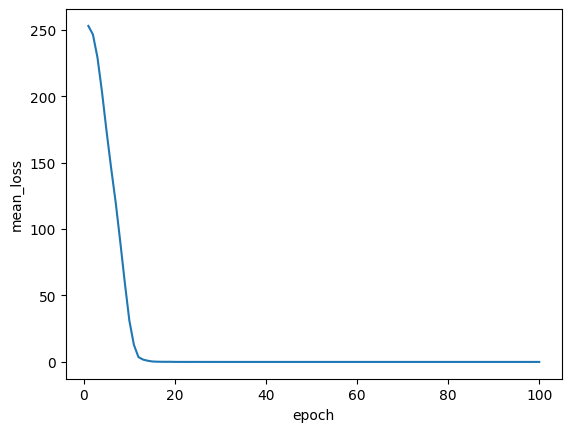

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')